In [1465]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
from scipy.optimize import minimize

import random
import warnings

pd.set_option('display.max_columns', None)

In [1466]:
data = pd.read_csv("data/raw/chap3_data.csv")

df = data.copy()

In [1467]:
df['is_foreign'] = (df['Type'] == 'Foreign').astype(int)
df['is_regular_fuel'] = (df['FuelType'] == 'レギュラー').astype(int)

# 年ダミー作成（year_2006を基準に除外）
year_dummies = pd.get_dummies(df['year'], prefix='year')

# 'year_2006'を削除
year_2006_cols = [col for col in year_dummies.columns if '2006' in col]
year_dummies = year_dummies.drop(year_2006_cols, axis=1)

df = pd.concat([df, year_dummies], axis=1)
df['year'] = pd.to_numeric(df['year'], errors='coerce')

# capacityダミー（4以下と5以上で分ける）
df['capacity_d'] = (df['capacity'] > 4).astype(int)

# ダミー変数を最後の列に移動
dummy_cols = [col for col in df.columns if col.startswith('Type_') or col.startswith('year_') or col.startswith('Maker_')]
other_cols = [col for col in df.columns if col not in dummy_cols]
df = df[other_cols + dummy_cols]
df[dummy_cols] = df[dummy_cols].astype(int)


In [1468]:
df.reset_index(drop=True, inplace=True)
# mean utility
df['cons'] = 1
X1 = df.copy()
X1 = X1[['cons','price','FuelEfficiency','hppw','size','capacity_d', 'is_foreign','is_regular_fuel'] + dummy_cols]

# nonlinear coef
X2 = df.copy()
X2 = X2[['price']]

# IV matrix
Z = df.copy()
Z = Z[[col for col in Z.columns if (col in ['cons','FuelEfficiency','hppw','size','capacity_d', 'is_foreign','is_regular_fuel'] + dummy_cols) or (col.startswith('iv_GH') and not col.endswith('nest'))]]

# market share
share_vec = df.copy()
share_vec = share_vec['share'].to_numpy()

# Bundle matrices into a dictionary
datalist = {
    'X1': X1,
    'X2': X2,
    'Z': Z,
    'ShareVec': share_vec,
    'marketindex': df['year'].values,
    'logitshare': df['logit_share'].values
}

n = df.shape[0]
t = len(df['year'].unique())

In [1469]:
random_state = 1111
np.random.seed(random_state)

nsim = 1000

draw_vec = np.random.randn(nsim * X2.shape[1])
datalist['draw_vec'] = draw_vec

# Parameters dictionary
parameter = {
    'Nsim': nsim,
    'T': t,
    'N': n,
    'theta2': [0.001] # price
}

# Construct tempmat for market indexing
marketindex = datalist['marketindex']
uniquemarketindex = np.sort(np.unique(marketindex))
temp1 = np.tile(uniquemarketindex, (n, 1))
temp2 = np.tile(marketindex, (t, 1)).T
tempmat = (temp1 == temp2).astype(int)
datalist['tempmat'] = tempmat

In [1470]:
def f_mktshare(datalist, parameter, delta, theta2):
    
    X2 = datalist['X2'].to_numpy()
    ns = parameter['Nsim']
    t = parameter['T']
    n = parameter['N']
    draw_vec = datalist['draw_vec']

    k2 = len(theta2)
    draw_vec = datalist['draw_vec'][:ns * k2]
    market_index = datalist['marketindex']
    
    # numerator
    mu = X2 @ np.diag(theta2) @ draw_vec.reshape(k2, ns)
    delta_mu = delta  @ np.ones((1, ns)) + mu
    exp_delta_mu = np.exp(delta_mu)
    
    # denominator
    denom_outside = np.exp(np.zeros((t,ns)))
    tempmat = datalist['tempmat']
    denom_temp = (tempmat.T @ exp_delta_mu)
    denom_temp += denom_outside
    denom = tempmat @ denom_temp
    
    s_jt_i = np.array(exp_delta_mu) / np.array(denom)
    s_jt = s_jt_i.mean(axis=1)
    
    return s_jt

def f_contraction(datalist, parameter, delta_ini, theta2):
    
    tol = 1e-11
    norm = 1e+10
    share_obs = datalist['ShareVec'].reshape(-1, 1)

    delta_old = delta_ini.copy()
    
    iter = 0

    while norm > tol and iter < 1000:
        pred_mkt_share = f_mktshare(datalist, parameter, delta_old, theta2)
        updated_delta = delta_old + np.log(share_obs) - np.log(pred_mkt_share.reshape(-1, 1))
        norms = np.abs(updated_delta - delta_old)
        norm = np.max(norms)

        delta_old = updated_delta
        iter += 1

    return delta_old

def f_GMMobj(theta2, parameter, datalist, option):
    global delta_global
    param = parameter.copy()
    param['theta2'] = theta2

    delta_ini = delta_global.copy()
    delta = f_contraction(datalist, param, delta_ini, theta2)
    delta_global = delta

    X1 = datalist['X1'].to_numpy()
    Z = datalist['Z'].to_numpy()

    if datalist['weight_mat_option'] == "2SLS":
        W = np.linalg.inv(Z.T @ Z) # weighted matrix = inverse of (inner product of transposed Z and Z)
    elif datalist['weight_mat_option'] == "Ident":
        W = np.eye(Z.shape[1]) # weighted matrix = identity matrix
    else:
        raise ValueError("SET 'datalist['weight_mat_option']' !")

    beta_hat = np.linalg.inv(X1.T @ Z @ W @ Z.T @ X1) @ (X1.T @ Z @ W @ Z.T @ delta)
    Xi = delta - X1 @ beta_hat
    obj = Xi.T @ Z @ W @ Z.T @ Xi

    if option == 0:
        return obj
    elif option == 1:
        return {'output': obj, 'beta_hat': beta_hat, 'delta': delta, 'Xi': Xi}
    else:
        raise ValueError("SET the argument 'option' to 0 or 1 !!")

In [1471]:
datalist['weight_mat_option'] = "2SLS"

delta_global = df['logit_share'].values.reshape(-1, 1)

# initial param（heterogeneity of [price]）
initial_theta2 = np.array([0.3])
bounds = [(0, None)]  # 非負制約

# 最適化
result = minimize(
    fun=lambda theta2: f_GMMobj(theta2, parameter, datalist, option=0),
    x0=initial_theta2,
    method='L-BFGS-B',
    bounds=bounds
)

result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 147.13472726287372
        x: [ 7.291e-01]
      nit: 8
      jac: [ 1.847e-04]
     nfev: 28
     njev: 14
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [1472]:
def f_SE(theta2, parameter, datalist):
    param = parameter
    param['theta2'] = theta2
    
    delta_ini = datalist['logitshare'].reshape(-1, 1)
    
    # contraction mapping
    delta = f_contraction(datalist, param, delta_ini, theta2)
    
    # object func
    X1 = datalist['X1'].to_numpy()
    Z = datalist['Z'].to_numpy()
    
    if datalist['weight_mat_option'] == "2SLS":
        W = np.linalg.inv(Z.T @ Z)
    elif datalist['weight_mat_option'] == "Ident":
        W = np.eye(Z.shape[1])
    else:
        raise ValueError("SET 'datalist['weight_mat_option']' !!")

    beta_hat = np.linalg.inv(X1.T @ Z @ W @ Z.T @ X1) @ (X1.T @ Z @ W @ Z.T @ delta)
    Xi = delta - (X1 @ beta_hat)

    Omega_hat = np.zeros((Z.shape[1], Z.shape[1]))
    for ii in range(param['N']):
        Zi = Z[ii, :].reshape(-1, 1)
        Omega_hat = Omega_hat + ((Zi @ Zi.T) * (Xi[ii] ** 2)) / param['N']

    Ddelta = np.zeros((param['N'], len(theta2)))
    for k in range(len(theta2)):
        tempparam = param.copy()
        tempparam['theta2'][k] += 1e-6
        delta_add = f_contraction(datalist, tempparam, delta_ini, theta2)
        Ddelta[:, k] = ((delta_add - delta) / 1e-6).ravel()

    G = (1 / param['N']) * Z.T @ np.hstack([-X1, Ddelta])

    temp = np.linalg.inv(G.T @ W @ G)
    AsyVarMat = temp @ (G.T @ W @ Omega_hat @ W @ G) @ temp
    Ase = np.sqrt(np.diag(AsyVarMat) / param['N'])

    return Ase

In [1473]:
result2 = f_GMMobj(result['x'], parameter, datalist, option=1)

delta = result2['delta']
Xi = result2['Xi']

df['delta'] = delta
df['Xi'] = Xi

se = f_SE(theta2=result['x'], parameter=parameter, datalist=datalist)

beta_hat = np.vstack([result2['beta_hat'], result['x'][0]])
beta_labels = ['const', 'price', 'FuelEfficiency', 'hppw', 'size', 'capacity_d','Foreign_d', 'FuelRegular_d'] + dummy_cols + ['random_price']

result_table = pd.DataFrame(beta_hat, columns=['coeff'], index=beta_labels)
result_table['se'] = se

print(result_table)

                    coeff        se
const          -13.725131  0.623539
price           -2.324289  0.757111
FuelEfficiency   0.194014  0.012524
hppw            13.605995  3.190707
size             0.534852  0.069967
capacity_d      -0.299182  0.135664
Foreign_d        0.995205  0.174346
FuelRegular_d   -1.048794  0.258198
year_2007       -0.099389  0.150975
year_2008       -0.250929  0.147975
year_2009       -0.482423  0.147338
year_2010       -0.623885  0.164765
year_2011       -0.836906  0.167683
year_2012       -0.699481  0.169326
year_2013       -0.850647  0.171628
year_2014       -1.041320  0.183459
year_2015       -1.139958  0.180853
year_2016       -1.245070  0.183400
random_price     0.729128  0.242058


In [1474]:
beta_hat = pd.DataFrame(beta_hat, columns=['coeff'], index=beta_labels)

def f_elasticity(datalist, parameter, beta_hat, theta2, delta):
    
    X2 = datalist['X2'].to_numpy()
    ns = parameter['Nsim']
    n = parameter['N']
    # theta2 = parameter['theta2']
    k2 = len(theta2)
    draw_vec = datalist['draw_vec'][:ns * k2]
    price = datalist['X1']['price'].values.reshape(-1, 1)
    uniquemarketindex = np.sort(np.unique(datalist['marketindex'])) # datalistにuniquemarketindexはおそらくない
    marketindex = datalist['marketindex']
    t = len(uniquemarketindex)

    denom_outside = np.exp(np.zeros((t,ns)))
    mu = X2 @ np.diag(theta2) @ draw_vec.reshape(k2, ns)
    delta_mu = delta @ np.ones((1, ns)) + mu
    exp_delta_mu = np.exp(delta_mu)
    tempmat = datalist['tempmat']
    denom_temp = (tempmat.T @ exp_delta_mu)
    denom_temp += denom_outside
    denom = tempmat @ denom_temp
    s_jt_i = np.array(exp_delta_mu) / np.array(denom)

    draw_for_price = draw_vec.reshape(k2, ns) # priceは[1] [0]だとconstのランダム抽出
    alpha_i = beta_hat.loc['price'].values  + beta_hat.loc['random_price'].values * draw_for_price

    elaslist = []

    # Create elas matrix for each market
    for tau, year in enumerate(uniquemarketindex):
        J_t = np.sum(marketindex == year)
        ag_model_s_i = s_jt_i[marketindex == year, :]
        ag_model_s = np.mean(ag_model_s_i, axis=1).reshape(-1, 1)
        elasmat = np.zeros((J_t, J_t))
        price_t = price[marketindex == year].flatten()

        # Compute elas
        for k in range(J_t):
            for j in range(J_t):
                if k != j: # cross elas
                    elasmat[k, j] = -price_t[k] * (1 / ag_model_s[j, 0]) * np.mean(alpha_i * ag_model_s_i[j, :] * ag_model_s_i[k, :])
                else: # own elas
                    elasmat[k, j] = price_t[j] * (1 / ag_model_s[j, 0]) * np.mean(alpha_i * ag_model_s_i[j, :] * (1 - ag_model_s_i[j, :]))
        
        elaslist.append({
            f"elasmat_{year}": elasmat
        })

    return elaslist

In [1475]:
df['Maker'] = df['Maker'].replace({
    'Honda': 'Nippyo',
    'Nissan': 'Brand_A',
    'Subaru': 'Brand_B',
    'Toyota': 'Brand_C'
})

In [1476]:
def f_mc(data, datalist, elaslist):

    mc_dict = {}
    
    for tau in range(t):

        J_t = np.sum(marketindex == (2005 + tau + 1))
        df_t = data[marketindex == (2005 + tau + 1)].copy()

        price_vec_t = df_t['price'].values
        share_vec_t = datalist['ShareVec'][marketindex == (2005 + tau + 1)].copy()

        elas_t = elaslist[tau][f"elasmat_{2005 + tau + 1}"]

        owner_mat_t = np.zeros((J_t, J_t))

        for j in range(J_t):
            for k in range(J_t):
                if df_t['Maker'].values[j] == df_t['Maker'].values[k]:
                    owner_mat_t[j, k] = 1
                else:
                    owner_mat_t[j, k] = 0

        derivative_t = - (elas_t)*(np.kron(np.ones((J_t,1)), share_vec_t.reshape(1,-1))) / (np.kron(np.ones((1,J_t)), price_vec_t.reshape(-1, 1)))

        Delta_t = derivative_t * owner_mat_t 
        
        #mc_t = price_vec_t - (np.linalg.inv(Delta_t) @ share_vec_t)
        mc_t = price_vec_t - (np.linalg.solve(Delta_t,share_vec_t))

        mc_df_t = pd.DataFrame({
                'Name': df_t['Name'],
                'NameID': df_t['NameID'],
                'Maker': df_t['Maker'],
                'price': price_vec_t,
                'mc': mc_t
                })
        mc_df_t['margin'] = (mc_df_t['price'] - mc_df_t['mc']) / mc_df_t['price']
        
        key = f"mc_{2005 + tau + 1}"
        mc_dict[key] = mc_df_t
    
    return mc_dict

In [1477]:
elaslist = f_elasticity(datalist, parameter, beta_hat, result['x'], delta)
mc = f_mc(data=df,datalist=datalist, elaslist=elaslist)

<Axes: xlabel='margin', ylabel='Count'>

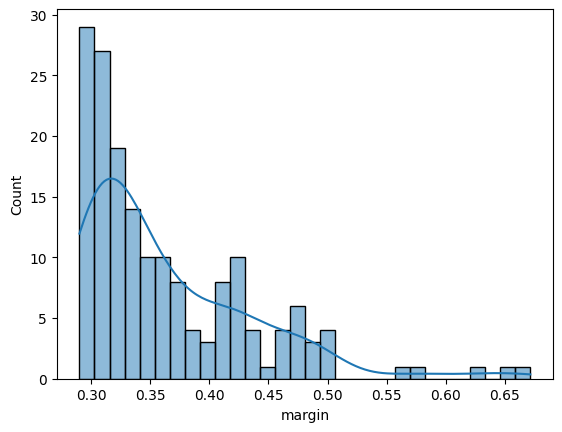

In [1478]:
import seaborn as sns
sns.histplot(mc['mc_2016']['margin'], bins=30, kde=True)

In [1479]:

df_2016 = df[df['year']==2016].copy()

df_2016 = df_2016.merge(mc['mc_2016'], on=['NameID', 'Maker', 'Name', 'price'], how='left')

maker = df_2016['Maker'].to_numpy()
df_2016['MakerNippyo_A'] = df_2016['Maker'].replace({'Nippyo': 'Nippyo_A', 'Brand_A': 'Nippyo_A'})
df_2016['MakerNippyo_B'] = df_2016['Maker'].replace({'Nippyo': 'Nippyo_B', 'Brand_B': 'Nippyo_B'})
makerA = df_2016['MakerNippyo_A'].to_numpy()
makerB = df_2016['MakerNippyo_B'].to_numpy()


Ownership_true = (maker[:, None] == maker[None, :]).astype(int)
Ownership_NippyoA = (makerA[:, None] == makerA[None, :]).astype(int)
Ownership_NippyoB = (makerB[:, None] == makerB[None, :]).astype(int)

In [1480]:
# ...existing code...
#df_2016.sort_values(by=['Maker'], inplace=True)

# mean utility
df_2016['cons'] = 1
X1_2016 = df_2016.copy()
X1_2016 = X1_2016[['cons','price','FuelEfficiency','hppw','size','capacity_d', 'is_foreign','is_regular_fuel'] + dummy_cols]

# nonlinear coef
X2_2016 = df_2016.copy()
X2_2016 = X2_2016[['price']]

# IV matrix
Z_2016 = df_2016.copy()
Z_2016 = Z_2016[[col for col in Z_2016.columns if (col in ['cons','FuelEfficiency','hppw','size','capacity_d', 'is_foreign','is_regular_fuel'] + dummy_cols) or (col.startswith('iv_GH') and not col.endswith('nest'))]]

# market share
share_vec_2016 = df_2016.copy()
share_vec_2016 = share_vec_2016['share'].to_numpy()

# Bundle matrices into a dictionary
datalist_2016 = {
    'X1': X1_2016,
    'X2': X2_2016,
    'Z': Z_2016,
    'ShareVec': share_vec_2016,
    'marketindex': df_2016['year'].values,
    'logitshare': df_2016['logit_share'].values
}

n_2016 = df_2016.shape[0]
t_2016 = len(df_2016['year'].unique())

In [1481]:
random_state = 1111
np.random.seed(random_state)

nsim_2016 = 1000

draw_vec_2016 = np.random.randn(nsim_2016 * X2_2016.shape[1])
datalist_2016['draw_vec'] = draw_vec_2016

# Parameters dictionary
parameter_2016 = {
    'Nsim': nsim_2016,
    'T': t_2016,
    'N': n_2016,
    'theta2': [0.729128] # price
}

# Construct tempmat for market indexing
marketindex_2016 = datalist_2016['marketindex']
uniquemarketindex_2016 = np.sort(np.unique(marketindex_2016))
temp1_2016 = np.tile(uniquemarketindex_2016, (n_2016, 1))
temp2_2016 = np.tile(marketindex_2016, (t_2016, 1)).T
tempmat_2016 = (temp1_2016 == temp2_2016).astype(int)
datalist_2016['tempmat'] = tempmat_2016

In [1482]:
mc = df_2016["mc"].to_numpy().reshape(-1, 1)
Xi = df_2016["Xi"].to_numpy().reshape(-1, 1)

In [1483]:
def f_update(datalist, p_old, Ownership, parameter, theta1, theta2, mc, Xi):
    
    datalist['X1']['price'] = p_old
    datalist['X2']['price'] = p_old
    
    X1 = datalist['X1'].to_numpy()

    delta = (X1 @ theta1.drop('random_price')) + Xi
    parameter['theta2'] = theta2

    Sharevec = f_mktshare(datalist, parameter, delta, theta2)
    
    elas = f_elasticity(datalist, parameter, theta1, theta2, delta)
    elasmat = list(elas[0].values())[0]
    J = len(p_old)
    Derivative = - (elasmat) * (np.kron(np.ones((J,1)), Sharevec.reshape(1,-1))) / np.kron(np.ones((1,J)), p_old.reshape(-1, 1))
    
    Delta = Ownership * Derivative 
    #p_new = mc + np.linalg.solve(Delta, Sharevec.reshape(-1,1))
    p_new = mc + (np.linalg.inv(Delta) @ Sharevec.reshape(-1,1)).reshape(-1, 1)
    print(p_new[78])
    return p_new

def f_eqprice(datalist, p_ini, Ownership, parameter, theta1, theta2, mc, Xi):
    
    tol = 1e-6
    p_old = p_ini.copy()
    norm = 10000
    
    while norm > tol:
        p_new = f_update(datalist, p_old, Ownership, parameter, theta1, theta2, mc, Xi)
        norm = np.max(np.abs(p_new - p_old))
        p_old = p_new

    return p_new

In [1484]:
p_ini = df_2016['price'].to_numpy()
p_NippyoA = f_eqprice(datalist_2016, p_ini, Ownership_NippyoA, parameter_2016, beta_hat, result['x'], mc, Xi)


[10.01180839]
[10.02177455]
[10.02371696]
[10.02409425]
[10.02416709]
[10.02418099]
[10.02418358]
[10.02418403]
[10.02418411]
[10.02418412]
[10.02418412]
[10.02418411]
[10.02418411]


In [1485]:
p_ini = df_2016['price'].to_numpy()
p_NippyoB = f_eqprice(datalist_2016, p_ini, Ownership_NippyoB, parameter_2016, beta_hat, result['x'], mc, Xi)

[9.96099927]
[9.96093547]
[9.96090999]
[9.96090223]
[9.96090012]
[9.96089958]
[9.96089946]
[9.96089943]
[9.96089942]
[9.96089942]
[9.96089942]
[9.96089943]


In [1486]:
def f_mktshare_sim(datalist, parameter, p_sim, beta_hat, theta2, Xi):
    
    datalist['X1']['price'] = p_sim
    datalist['X2']['price'] = p_sim
    
    X1 = datalist['X1'].to_numpy()
    
    delta_sim = (X1 @ beta_hat.drop('random_price')) + Xi
    share_sim = f_mktshare(datalist, parameter, delta_sim, theta2)
    
    return share_sim

In [1487]:
share_NippyoA = f_mktshare_sim(datalist_2016, parameter_2016, p_NippyoA, beta_hat, result['x'],  Xi)
share_NippyoB = f_mktshare_sim(datalist_2016, parameter_2016, p_NippyoB, beta_hat, result['x'],  Xi)

df_2016['price_NippyoA'] = p_NippyoA
df_2016['price_NippyoB'] = p_NippyoB
df_2016['share_NippyoA'] = share_NippyoA
df_2016['share_NippyoB'] = share_NippyoB

In [1488]:
df_2016_sim = df_2016.copy() 
table = pd.DataFrame({
    'Name': df_2016_sim['Name'],
    'Maker': df_2016_sim['Maker'],
    'price_NippyoA': (df_2016_sim['price_NippyoA'] - df_2016_sim['price'])/df_2016_sim['price']*100,
    'share_NippyoA': (df_2016_sim['share_NippyoA'] - df_2016_sim['share'])/df_2016_sim['share']*100,
    'price_NippyoB': (df_2016_sim['price_NippyoB'] - df_2016_sim['price'])/df_2016_sim['price']*100,
    'share_NippyoB': (df_2016_sim['share_NippyoB'] - df_2016_sim['share'])/df_2016_sim['share']*100})

#table

In [1489]:
def f_mc(data, datalist, elasmat):

    J_t = np.sum(marketindex == (2016))
    df_t = data.copy()

    price_vec_t = df_t['price'].values
    share_vec_t = datalist['ShareVec'].copy()

    elas_t = elasmat

    owner_mat_t = np.zeros((J_t, J_t))

    for j in range(J_t):
        for k in range(J_t):
            if df_t['Maker'].values[j] == df_t['Maker'].values[k]:
                owner_mat_t[j, k] = 1
            else:
                owner_mat_t[j, k] = 0

    derivative_t = - (elas_t)*(np.kron(np.ones((J_t,1)), share_vec_t.reshape(1,-1))) / (np.kron(np.ones((1,J_t)), price_vec_t.reshape(-1, 1)))

    Delta_t = derivative_t * owner_mat_t 
    
    #mc_t = price_vec_t - (np.linalg.inv(Delta_t) @ share_vec_t)
    mc_t = price_vec_t - (np.linalg.solve(Delta_t,share_vec_t))

    mc_df_t = pd.DataFrame({
            'Name': df_t['Name'],
            'NameID': df_t['NameID'],
            'Maker': df_t['Maker'],
            'price': price_vec_t,
            'mc': mc_t
            })
    mc_df_t['margin'] = (mc_df_t['price'] - mc_df_t['mc']) / mc_df_t['price']
    
    return mc_df_t

In [1490]:
elasmat_2016 = elaslist[10]['elasmat_2016']

df_2016_NippyoA = df_2016[['year','Maker','Name','NameID','price','share']].copy()

df_2016_NippyoA['Maker'] = df_2016['MakerNippyo_A']

mc_NippyoA_pfix = f_mc(data=df_2016_NippyoA,datalist=datalist_2016, elasmat=elasmat_2016)

df_2016_NippyoB = df_2016[['year','Maker','Name','NameID','price','share']].copy()

df_2016_NippyoB['Maker'] = df_2016['MakerNippyo_B']

mc_NippyoB_pfix = f_mc(data=df_2016_NippyoB,datalist=datalist_2016, elasmat=elasmat_2016)

In [1491]:
table2 = pd.DataFrame({
    'Name': df_2016['Name'],
    'Maker': df_2016['Maker'],
    'Nippyo and Brand A': (mc_NippyoA_pfix['mc'] - df_2016['mc'])/df_2016['mc']*100,
    'Nippyo and Brand B': (mc_NippyoB_pfix['mc'] - df_2016['mc'])/df_2016['mc']*100})

In [1492]:
def f_CS(datalist, p, param, theta1, theta2, Xi, HH):
    
    datalist['X1']['price'] = p
    datalist['X2']['price'] = p
    
    X1 = datalist['X1'].to_numpy()
    X2 = datalist['X2'].to_numpy()
    
    delta = (X1 @ theta1.drop('random_price').to_numpy()) + Xi

    
    ns = parameter['Nsim']
    n = parameter['N']
    k2 = len(theta2)
    draw_vec = datalist['draw_vec'][:ns * k2]
    uniquemarketindex = np.sort(np.unique(datalist['marketindex']))
    t = len(uniquemarketindex)

    denom_outside = np.exp(np.zeros((t,ns)))
    mu = X2 @ np.diag(theta2) @ draw_vec.reshape(k2, ns)
    V = delta @ np.ones((1, ns)) + mu
    exp_V = np.exp(V)
    
    numerator = np.log(np.sum(exp_V, axis=0) + np.exp(np.zeros((ns))))

    draw_for_price = draw_vec.reshape(k2, ns)[0,:]
    alpha_i = - (theta1.loc['price'].values  + (theta2 * draw_for_price))
    CS = np.mean(numerator / alpha_i) * HH
    
    return CS

In [1493]:
hh_2016 = df_2016['HH'].unique()[0]

# 基準（現状）シナリオ
cs_2016 = f_CS(datalist_2016, df_2016['price'],
               parameter_2016, beta_hat, result['x'], Xi, hh_2016)

# 政策シナリオA
cs_NippyoA = f_CS(datalist_2016, df_2016['price_NippyoA'],
                  parameter_2016, beta_hat, result['x'], Xi, hh_2016)

# 政策シナリオB
cs_NippyoB = f_CS(datalist_2016, df_2016['price_NippyoB'],
                  parameter_2016, beta_hat, result['x'], Xi, hh_2016)

# 補償的変分 (CV)
cv_NippyoA = cs_NippyoA - cs_2016
cv_NippyoB = cs_NippyoB - cs_2016

In [1494]:
def f_profit(Maker, p, mc, share, HH):
    
    pro_rev_dt = pd.DataFrame({
        'Maker': Maker,
        'profit_each': (p - mc)*share*HH,
        'revenue_each': p*share*HH
    })
    
    pro_rev = pro_rev_dt.groupby('Maker',as_index=False).agg(profit=('profit_each','sum'),revenue=('revenue_each', 'sum'))
    
    return pro_rev

In [1509]:
ss_2016 = f_profit(df_2016['Maker'], df_2016['price'], df_2016['mc'], df_2016['share'], hh_2016)
ss_NippyoA = f_profit(df_2016['Maker'], df_2016['price_NippyoA'], df_2016['mc'], df_2016['share_NippyoA'], hh_2016)
ss_NippyoB = f_profit(df_2016['Maker'], df_2016['price_NippyoB'], df_2016['mc'], df_2016['share_NippyoB'], hh_2016)

welfare_NippyoA = cv_NippyoA + np.sum(ss_NippyoA['profit'] - ss_2016['profit'])
welfare_NippyoB = cv_NippyoB + np.sum(ss_NippyoB['profit'] - ss_2016['profit'])